In [1]:
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning) 


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Helper Functions & Classes

In [2]:
# Hyperparameters
valid_size = 0.2
batch_size = 10
lr=0.001
n_epochs = 100

# Parameter Definition
num_workers = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck']
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

random_seed = 42
torch.manual_seed(random_seed)

# Define denormalizer
de_mean = [-mean/std for mean, std in zip(mean, std)]
de_std = [1/std for std in std]
denormalizer = transforms.Normalize(mean=de_mean, std=de_std)

def spilt_train_valid(train_dataset, valid_set_size):
    valid_set_size = int(valid_set_size * len(train_dataset))
    train_set_size = len(train_dataset) - valid_set_size
    return random_split(train_dataset, [train_set_size, valid_set_size])

def load_cifar10(is_train, transform):
    return datasets.CIFAR10(root='data', train=is_train, 
                            transform=transform, download=True)

def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

def plot_confusion_matrix(conf_matrix, class_names, normalize=False, ax_display=True, title='Confusion Matrix'):
    _, ax = plt.subplots(figsize=(8,6))
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues,ax=ax, xticks_rotation=45, values_format='.2f')
    else:
        conf_matrix = conf_matrix.astype('int')
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
        disp.plot(cmap=plt.cm.Blues,ax=ax, xticks_rotation=45, values_format='d')
    if ax_display is False:
        left, right = plt.xlim()
        ax.spines['left'].set_position(('data', left))
        ax.spines['right'].set_position(('data', right))
        for edge_i in ['top', 'bottom', 'right', 'left']:
            ax.spines[edge_i].set_edgecolor("white")
    plt.title(title, fontdict={'size': 14})
    plt.tight_layout()
    plt.ylabel('True label', fontdict={'size': 14})
    plt.xlabel('Predicted label', fontdict={'size': 14})
    plt.show()

def plot_class_samples(samples, preds, values, title='Examples'):
  plt.figure(figsize=(12, 6))
  for idx in range(10):
      plt.subplot(2, 5, idx+1)
      img = denormalizer(samples[idx]).cpu().numpy()
      plt.imshow(np.transpose(img, (1, 2, 0))) 
      plt.title('True: {:s} (Pred: {:s})'.format(class_names[idx], class_names[preds[idx]]), 
                fontdict={'size': 10},
                color=("green" if preds[idx]==idx else "red"))
      plt.xlabel('Confidence value: {:.2f}'.format(values[idx]), 
                fontdict={'size'   : 10})
      plt.yticks([])
      plt.xticks([])
  plt.suptitle(title, fontdict={'size': 14})
  plt.tight_layout()
  plt.show()

## Data Augumentation

In [3]:
train_transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomGrayscale(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                                ])

test_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                                ])

## Data Loading

In [4]:
# Load train, validation and test datasets as iterators
# Data
train_ds = load_cifar10(is_train=True, transform=train_transform)
test_ds = load_cifar10(is_train=False, transform=test_transform)
train_ds, valid_ds = spilt_train_valid(train_ds, valid_size)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                         shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, 
                                         shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)

100%|██████████| 170498071/170498071 [00:16<00:00, 10113431.50it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Network Definition

In [6]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.7MB/s]


## Training

======================== Epoch: 1 ========================


100%|██████████| 4000/4000 [00:58<00:00, 68.24it/s]


Train loss: 1.388, Train acc: 53.6%


100%|██████████| 1000/1000 [00:07<00:00, 139.40it/s]


Valid loss: 0.946, Valid acc: 66.6%
Validation loss decreased (inf --> 0.946).


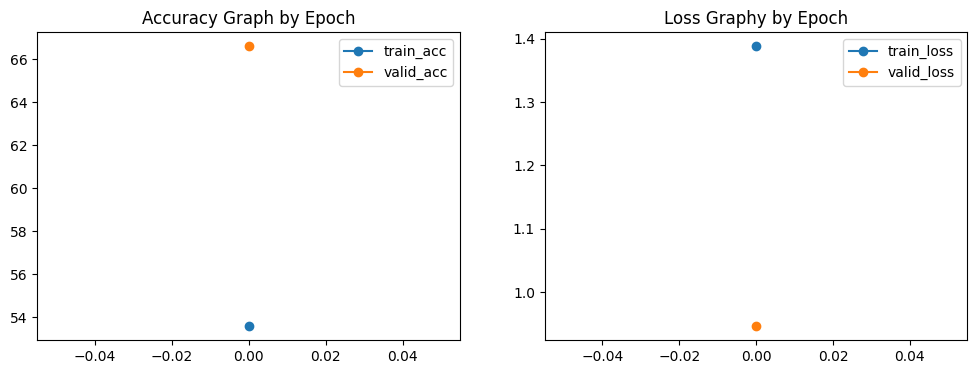

======================== Epoch: 2 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.76it/s]


Train loss: 1.007, Train acc: 66.6%


100%|██████████| 1000/1000 [00:07<00:00, 141.19it/s]


Valid loss: 0.779, Valid acc: 74.0%
Validation loss decreased (0.946 --> 0.779).


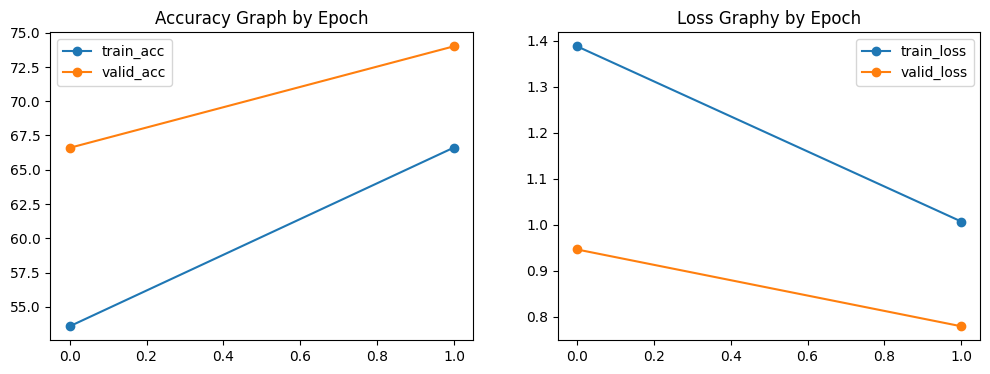

======================== Epoch: 3 ========================


100%|██████████| 4000/4000 [00:53<00:00, 74.13it/s]


Train loss: 0.846, Train acc: 71.7%


100%|██████████| 1000/1000 [00:07<00:00, 141.82it/s]


Valid loss: 0.717, Valid acc: 75.8%
Validation loss decreased (0.779 --> 0.717).


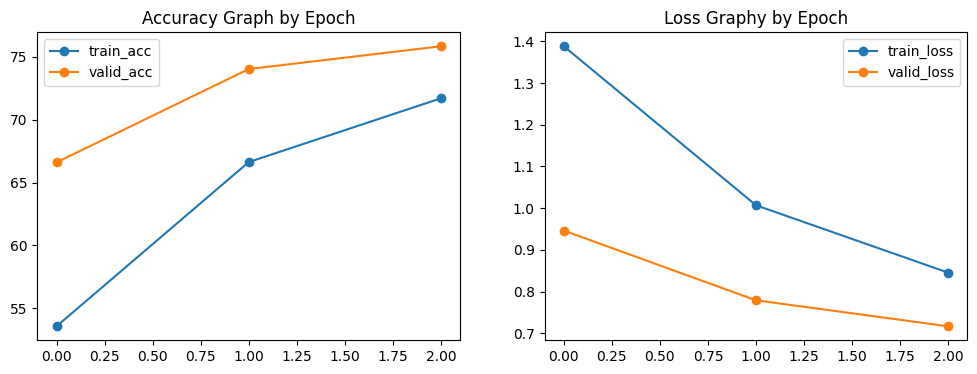

======================== Epoch: 4 ========================


100%|██████████| 4000/4000 [00:53<00:00, 74.30it/s]


Train loss: 0.764, Train acc: 74.6%


100%|██████████| 1000/1000 [00:06<00:00, 143.16it/s]


Valid loss: 0.635, Valid acc: 78.9%
Validation loss decreased (0.717 --> 0.635).


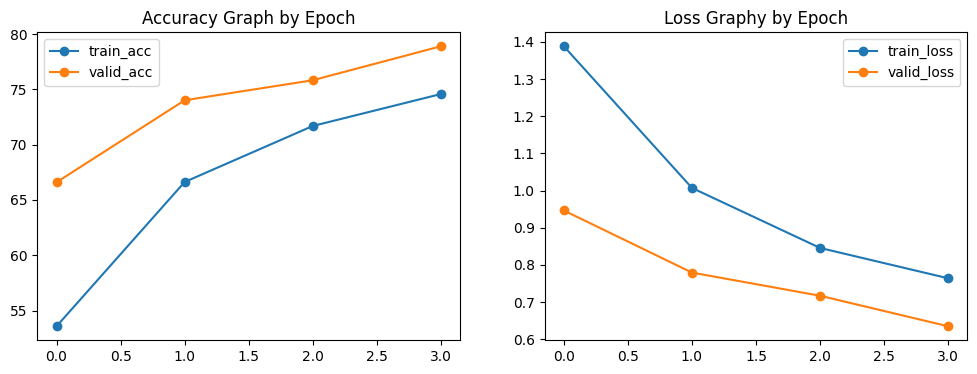

======================== Epoch: 5 ========================


100%|██████████| 4000/4000 [00:53<00:00, 74.16it/s]


Train loss: 0.683, Train acc: 77.2%


100%|██████████| 1000/1000 [00:07<00:00, 141.13it/s]


Valid loss: 0.684, Valid acc: 77.3%


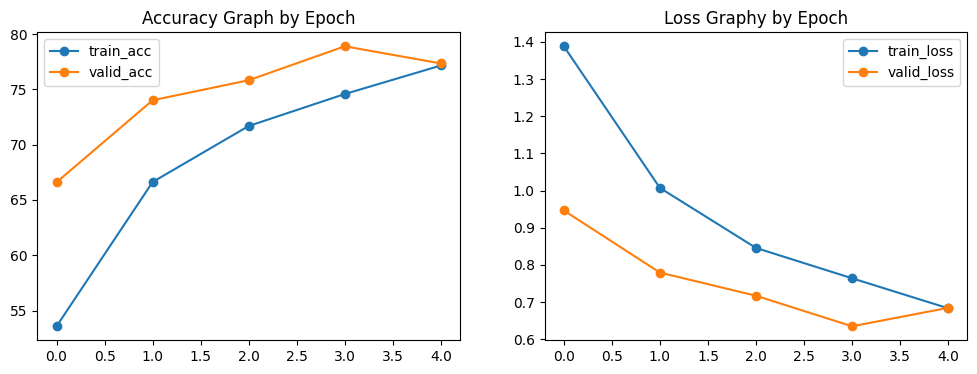

======================== Epoch: 6 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.78it/s]


Train loss: 0.624, Train acc: 79.5%


100%|██████████| 1000/1000 [00:06<00:00, 143.60it/s]


Valid loss: 0.643, Valid acc: 78.0%


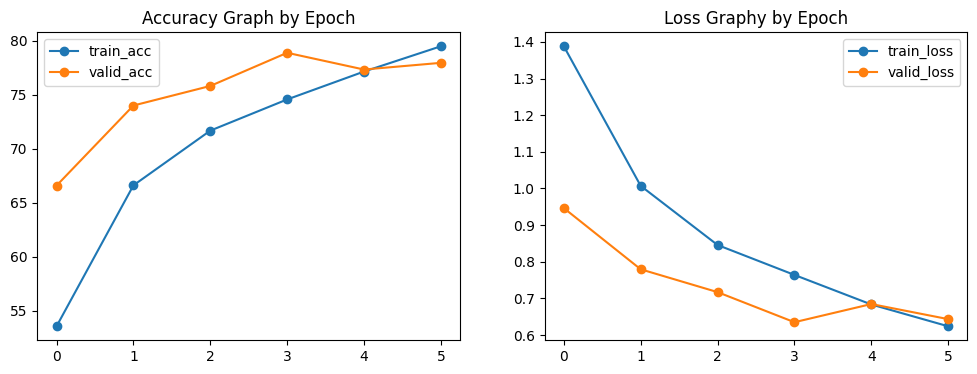

======================== Epoch: 7 ========================


100%|██████████| 4000/4000 [00:54<00:00, 74.01it/s]


Train loss: 0.579, Train acc: 80.7%


100%|██████████| 1000/1000 [00:07<00:00, 142.43it/s]


Valid loss: 0.578, Valid acc: 80.1%
Validation loss decreased (0.635 --> 0.578).


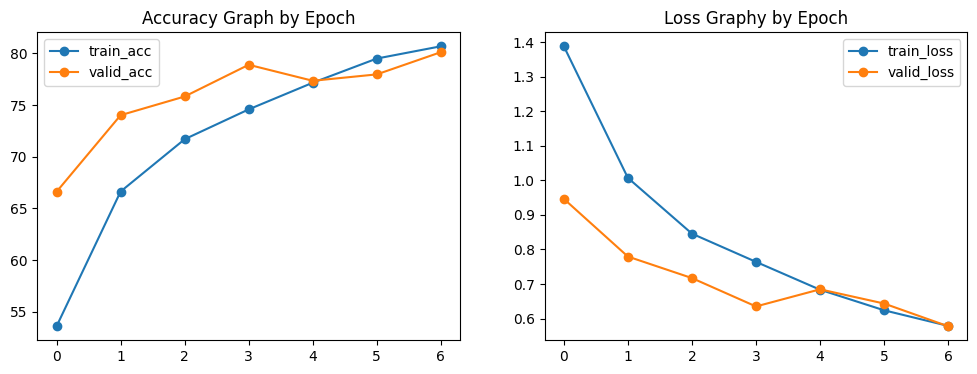

======================== Epoch: 8 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.11it/s]


Train loss: 0.546, Train acc: 81.8%


100%|██████████| 1000/1000 [00:07<00:00, 132.15it/s]


Valid loss: 0.584, Valid acc: 80.4%


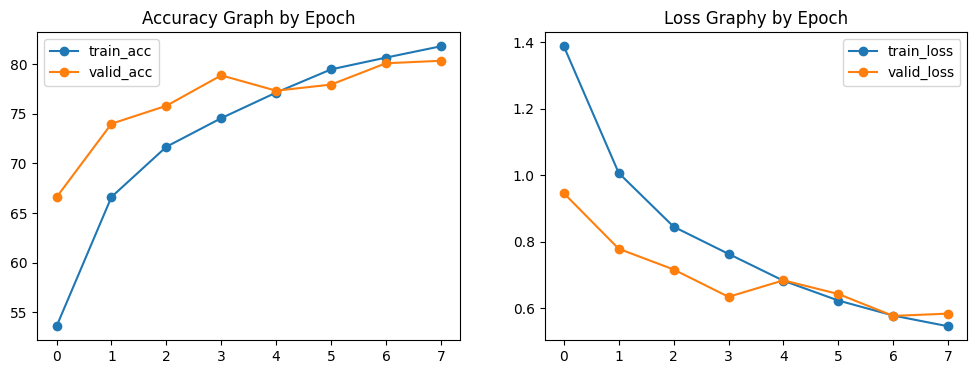

======================== Epoch: 9 ========================


100%|██████████| 4000/4000 [00:54<00:00, 72.80it/s]


Train loss: 0.509, Train acc: 83.2%


100%|██████████| 1000/1000 [00:07<00:00, 135.44it/s]


Valid loss: 0.679, Valid acc: 79.5%


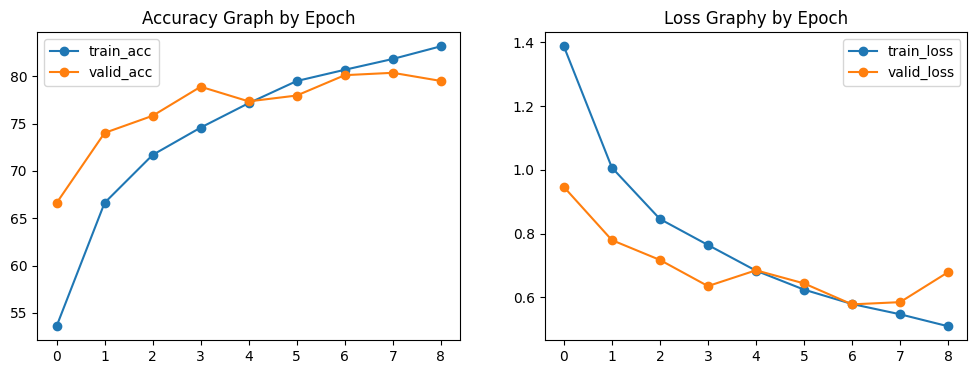

======================== Epoch: 10 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.69it/s]


Train loss: 0.479, Train acc: 83.8%


100%|██████████| 1000/1000 [00:07<00:00, 140.43it/s]


Valid loss: 0.576, Valid acc: 80.1%
Validation loss decreased (0.578 --> 0.576).


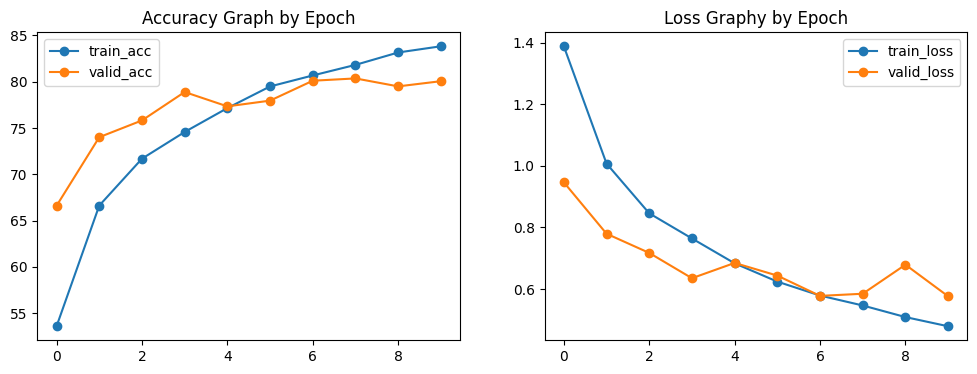

======================== Epoch: 11 ========================


100%|██████████| 4000/4000 [00:53<00:00, 74.19it/s]


Train loss: 0.450, Train acc: 85.0%


100%|██████████| 1000/1000 [00:07<00:00, 139.54it/s]


Valid loss: 0.531, Valid acc: 81.5%
Validation loss decreased (0.576 --> 0.531).


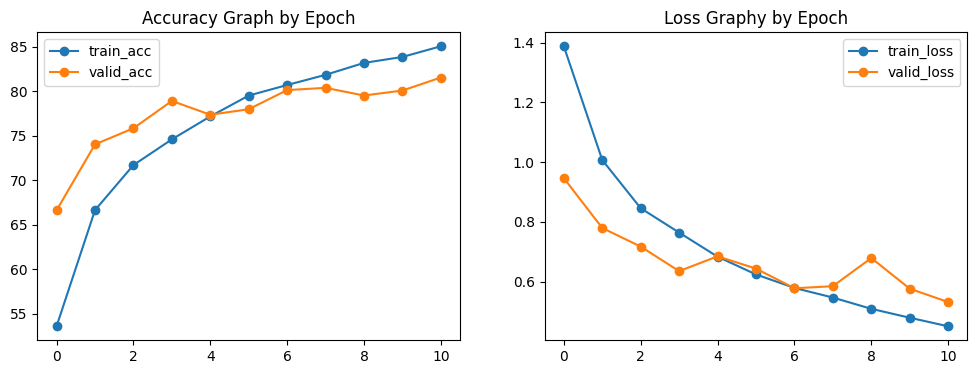

======================== Epoch: 12 ========================


100%|██████████| 4000/4000 [00:54<00:00, 74.07it/s]


Train loss: 0.416, Train acc: 86.1%


100%|██████████| 1000/1000 [00:07<00:00, 141.00it/s]


Valid loss: 0.520, Valid acc: 82.1%
Validation loss decreased (0.531 --> 0.520).


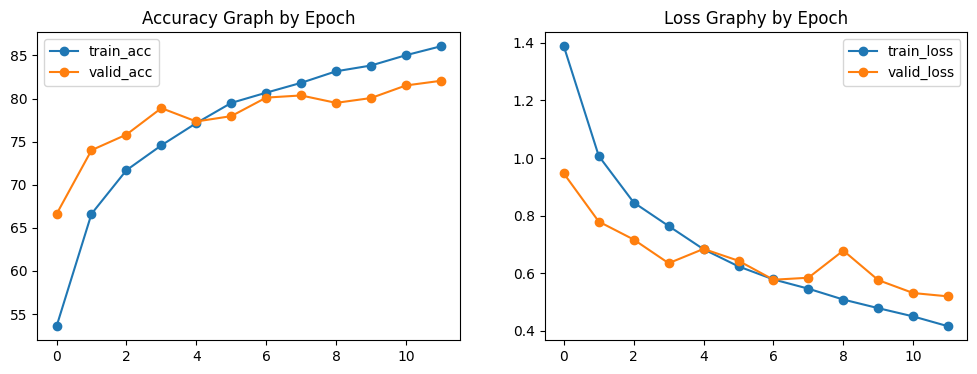

======================== Epoch: 13 ========================


100%|██████████| 4000/4000 [00:54<00:00, 74.02it/s]


Train loss: 0.404, Train acc: 86.8%


100%|██████████| 1000/1000 [00:07<00:00, 141.58it/s]


Valid loss: 0.532, Valid acc: 81.5%


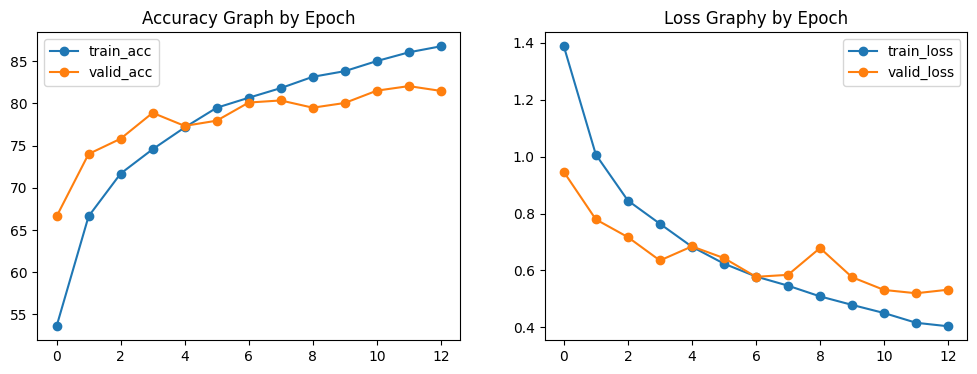

======================== Epoch: 14 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.86it/s]


Train loss: 0.375, Train acc: 87.6%


100%|██████████| 1000/1000 [00:07<00:00, 139.88it/s]


Valid loss: 0.527, Valid acc: 82.1%


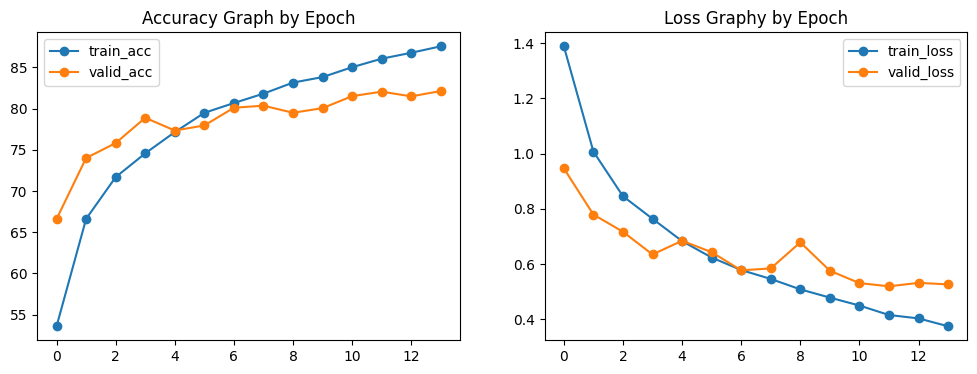

======================== Epoch: 15 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.84it/s]


Train loss: 0.344, Train acc: 88.4%


100%|██████████| 1000/1000 [00:07<00:00, 138.98it/s]


Valid loss: 0.538, Valid acc: 81.6%


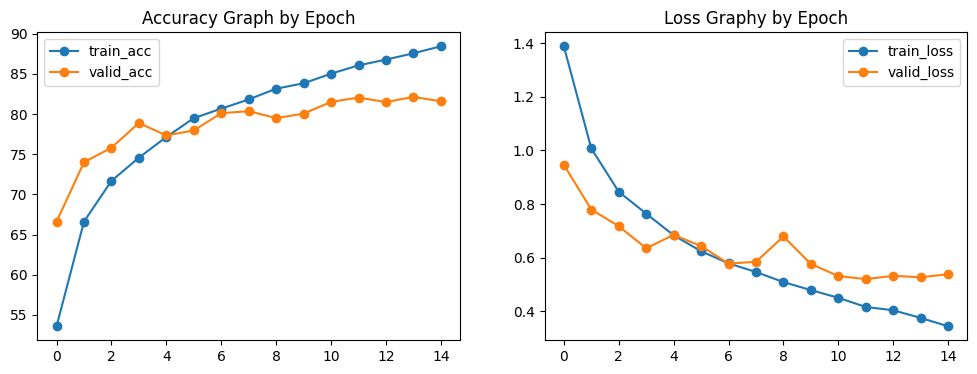

======================== Epoch: 16 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.73it/s]


Train loss: 0.329, Train acc: 89.0%


100%|██████████| 1000/1000 [00:07<00:00, 140.30it/s]


Valid loss: 0.570, Valid acc: 80.7%


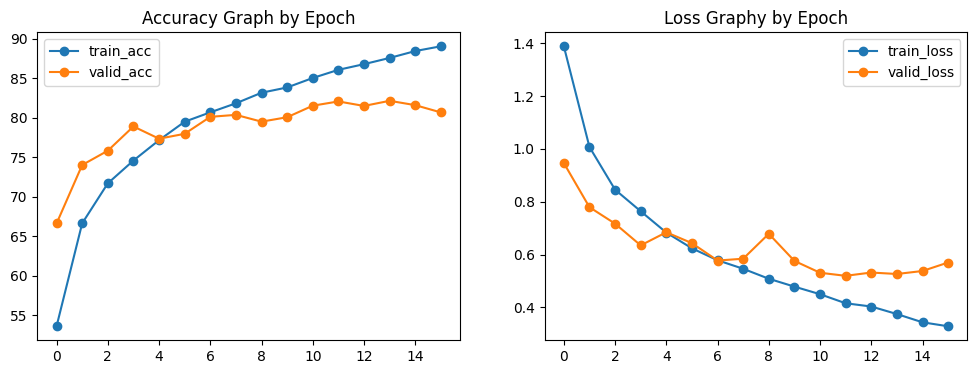

======================== Epoch: 17 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.68it/s]


Train loss: 0.315, Train acc: 89.4%


100%|██████████| 1000/1000 [00:07<00:00, 141.08it/s]


Valid loss: 0.535, Valid acc: 82.3%


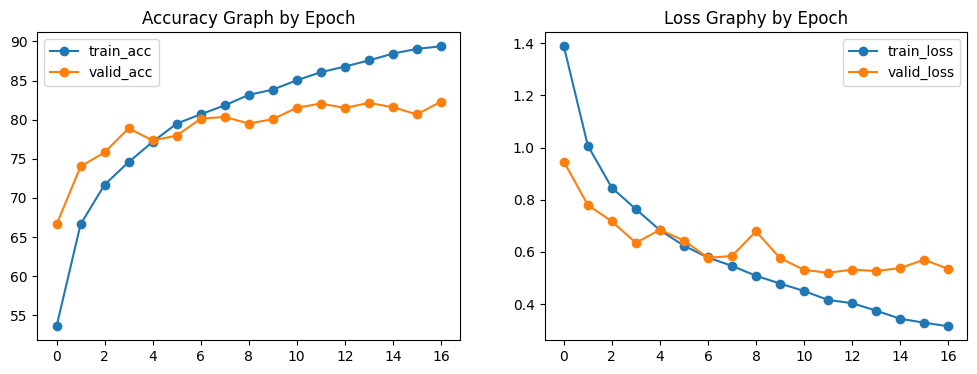

======================== Epoch: 18 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.89it/s]


Train loss: 0.295, Train acc: 90.2%


100%|██████████| 1000/1000 [00:07<00:00, 141.46it/s]


Valid loss: 0.524, Valid acc: 82.8%


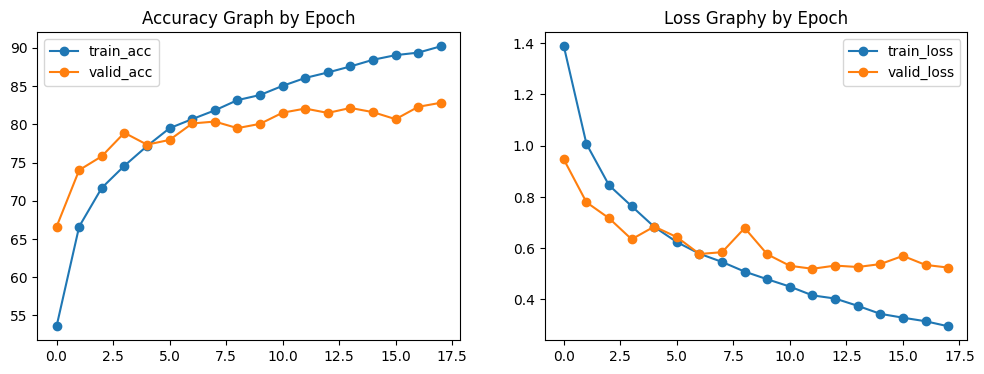

======================== Epoch: 19 ========================


100%|██████████| 4000/4000 [00:53<00:00, 74.09it/s]


Train loss: 0.280, Train acc: 90.7%


100%|██████████| 1000/1000 [00:07<00:00, 141.07it/s]


Valid loss: 0.512, Valid acc: 82.7%
Validation loss decreased (0.520 --> 0.512).


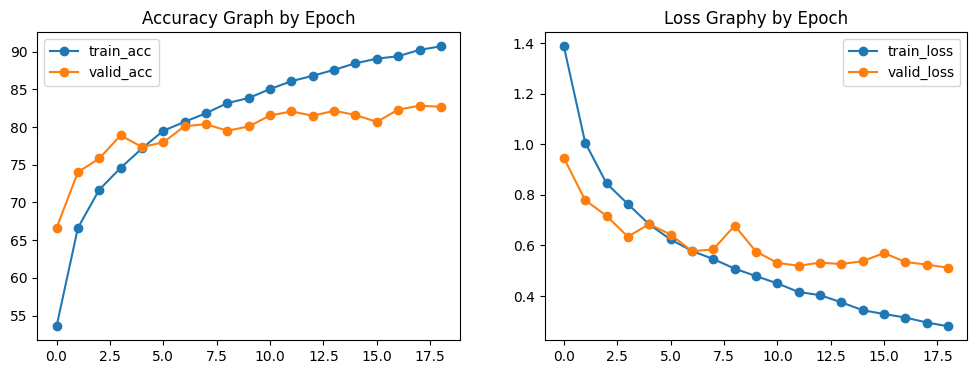

======================== Epoch: 20 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.96it/s]


Train loss: 0.270, Train acc: 90.9%


100%|██████████| 1000/1000 [00:07<00:00, 141.76it/s]


Valid loss: 0.548, Valid acc: 82.1%


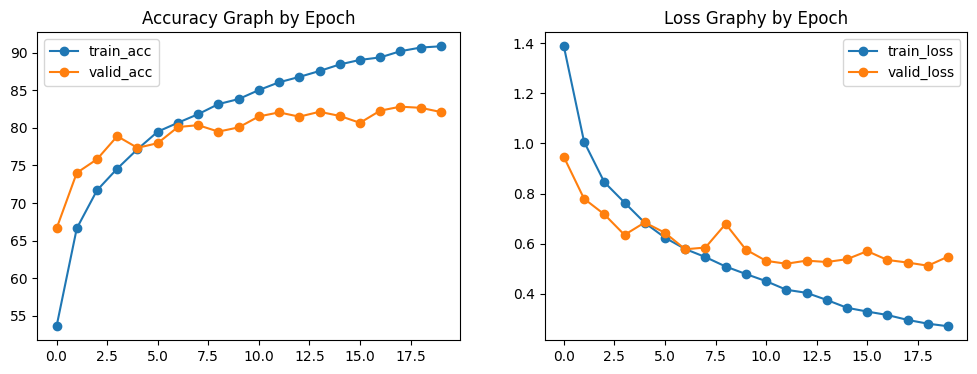

======================== Epoch: 21 ========================


100%|██████████| 4000/4000 [00:53<00:00, 74.31it/s]


Train loss: 0.250, Train acc: 91.7%


100%|██████████| 1000/1000 [00:07<00:00, 142.49it/s]


Valid loss: 0.554, Valid acc: 81.0%


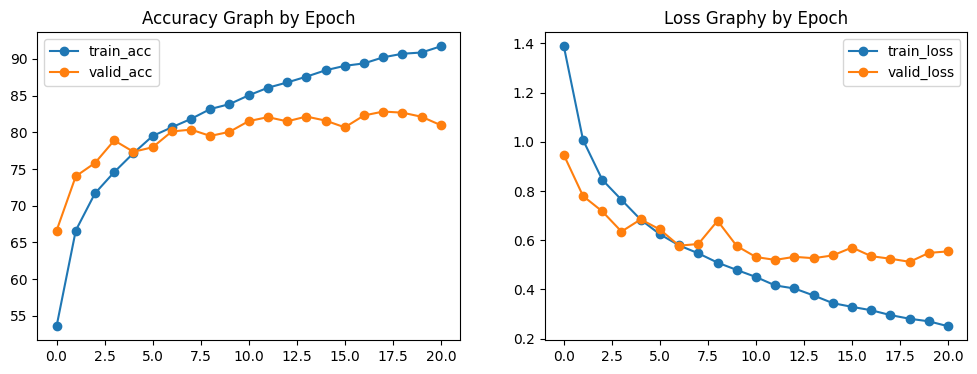

======================== Epoch: 22 ========================


100%|██████████| 4000/4000 [00:53<00:00, 74.12it/s]


Train loss: 0.246, Train acc: 91.9%


100%|██████████| 1000/1000 [00:07<00:00, 141.34it/s]


Valid loss: 0.531, Valid acc: 82.6%


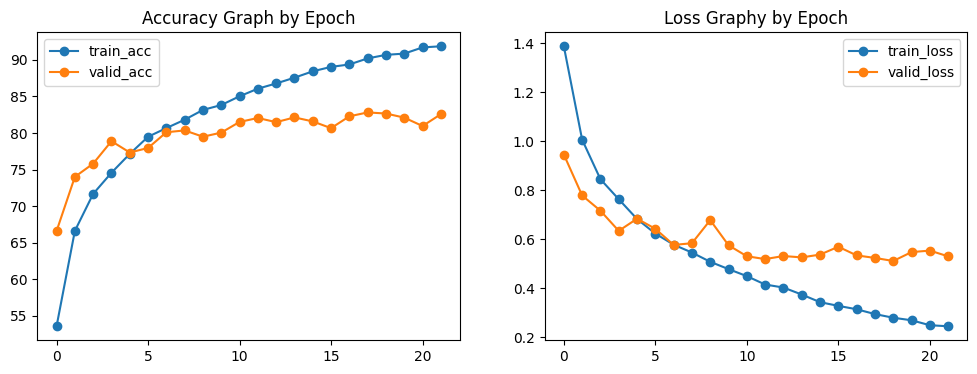

======================== Epoch: 23 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.41it/s]


Train loss: 0.218, Train acc: 92.6%


100%|██████████| 1000/1000 [00:07<00:00, 139.66it/s]


Valid loss: 0.723, Valid acc: 77.9%


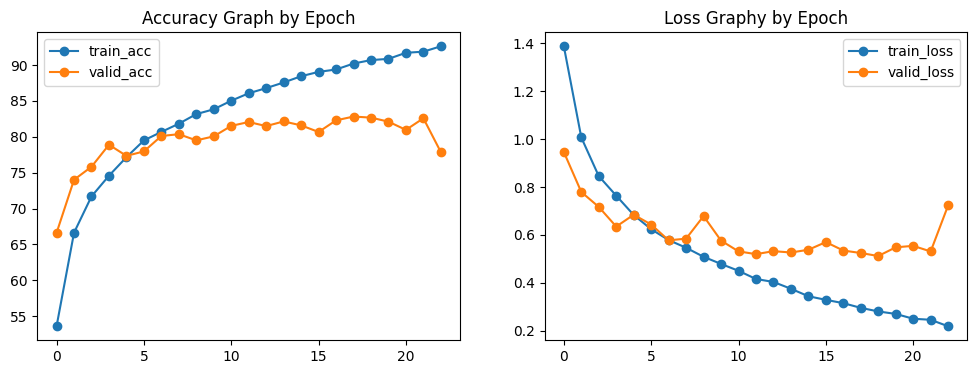

======================== Epoch: 24 ========================


100%|██████████| 4000/4000 [00:55<00:00, 72.06it/s]


Train loss: 0.208, Train acc: 93.0%


100%|██████████| 1000/1000 [00:07<00:00, 137.59it/s]


Valid loss: 0.557, Valid acc: 82.2%


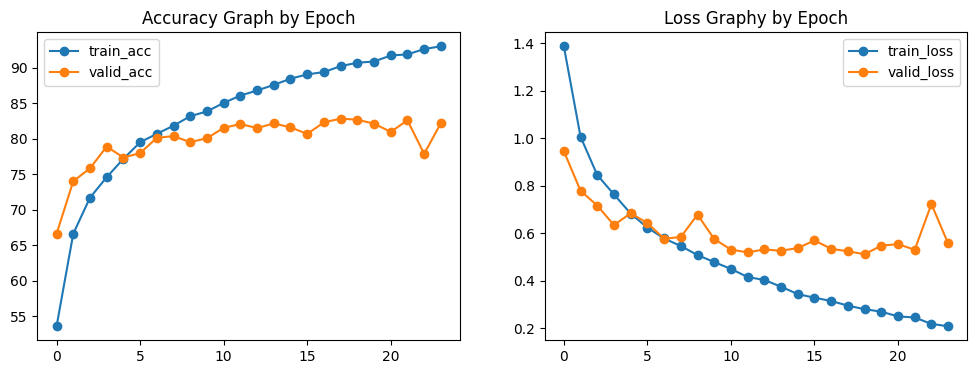

======================== Epoch: 25 ========================


100%|██████████| 4000/4000 [00:55<00:00, 71.54it/s]


Train loss: 0.208, Train acc: 92.9%


100%|██████████| 1000/1000 [00:07<00:00, 136.49it/s]


Valid loss: 0.542, Valid acc: 82.6%


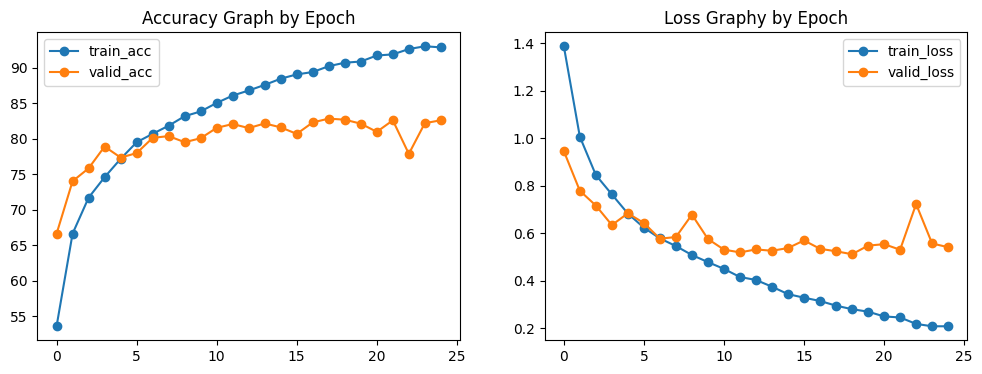

======================== Epoch: 26 ========================


100%|██████████| 4000/4000 [00:55<00:00, 71.49it/s]


Train loss: 0.189, Train acc: 93.7%


100%|██████████| 1000/1000 [00:07<00:00, 134.99it/s]


Valid loss: 0.564, Valid acc: 82.6%


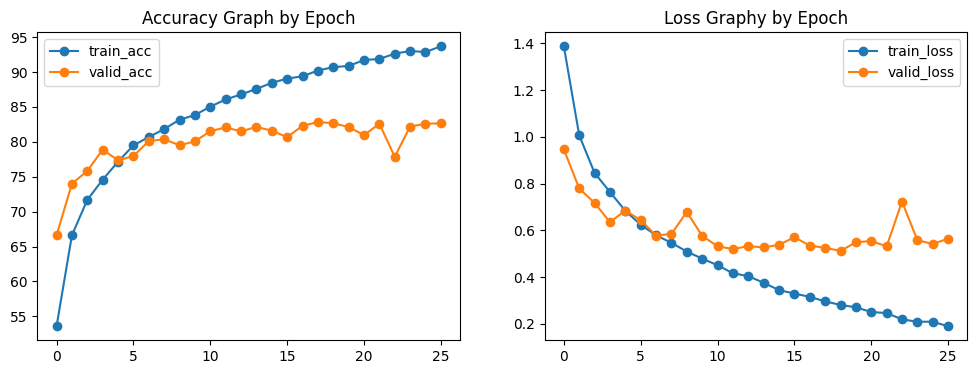

======================== Epoch: 27 ========================


100%|██████████| 4000/4000 [00:55<00:00, 71.75it/s]


Train loss: 0.187, Train acc: 93.7%


100%|██████████| 1000/1000 [00:07<00:00, 136.31it/s]


Valid loss: 0.543, Valid acc: 82.4%


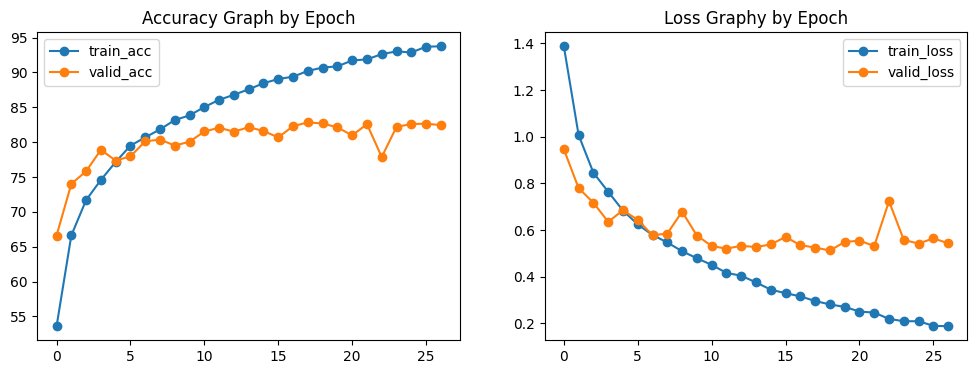

======================== Epoch: 28 ========================


100%|██████████| 4000/4000 [00:56<00:00, 71.38it/s]


Train loss: 0.180, Train acc: 94.0%


100%|██████████| 1000/1000 [00:07<00:00, 134.51it/s]


Valid loss: 0.558, Valid acc: 82.3%


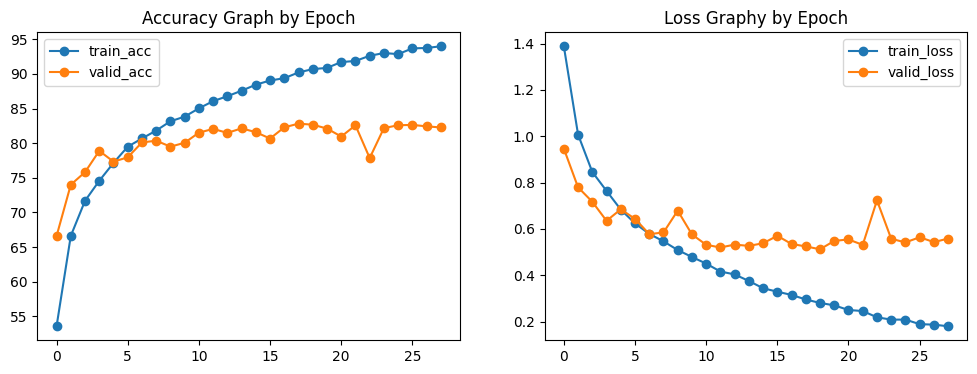

======================== Epoch: 29 ========================


100%|██████████| 4000/4000 [00:55<00:00, 71.51it/s]


Train loss: 0.178, Train acc: 94.1%


100%|██████████| 1000/1000 [00:07<00:00, 137.71it/s]


Valid loss: 0.548, Valid acc: 83.1%


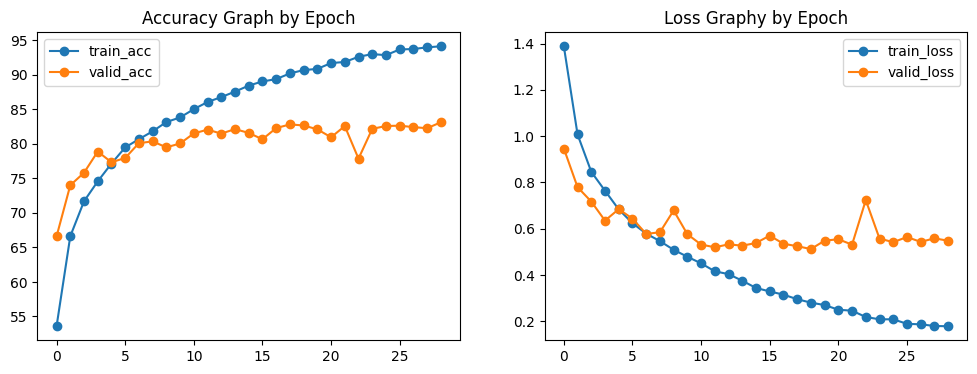

======================== Epoch: 30 ========================


100%|██████████| 4000/4000 [00:55<00:00, 71.59it/s]


Train loss: 0.165, Train acc: 94.4%


100%|██████████| 1000/1000 [00:07<00:00, 136.83it/s]


Valid loss: 0.571, Valid acc: 82.5%


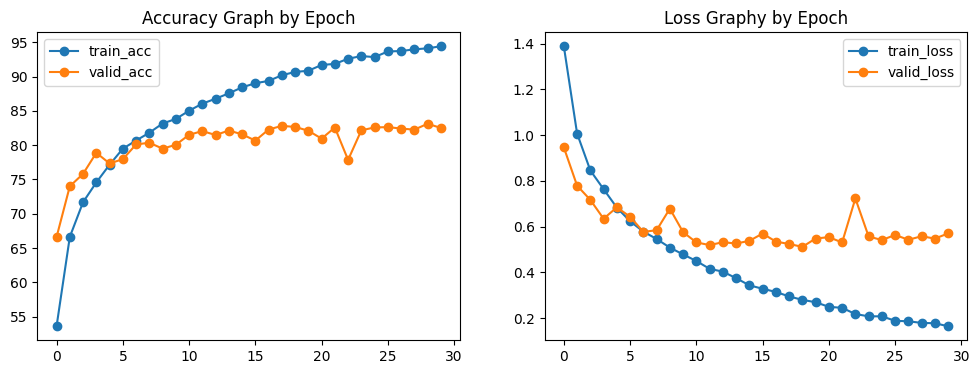

======================== Epoch: 31 ========================


100%|██████████| 4000/4000 [00:55<00:00, 71.58it/s]


Train loss: 0.159, Train acc: 94.7%


100%|██████████| 1000/1000 [00:07<00:00, 137.12it/s]


Valid loss: 0.587, Valid acc: 82.2%


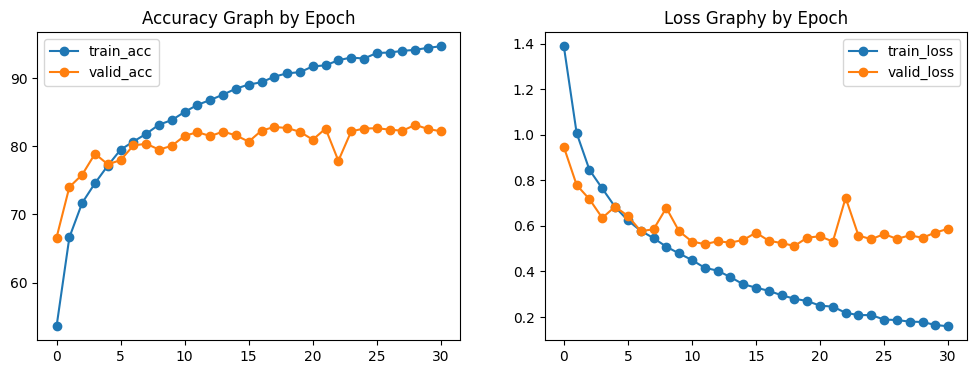

======================== Epoch: 32 ========================


100%|██████████| 4000/4000 [00:55<00:00, 71.48it/s]


Train loss: 0.147, Train acc: 95.2%


100%|██████████| 1000/1000 [00:07<00:00, 138.55it/s]


Valid loss: 0.551, Valid acc: 82.9%


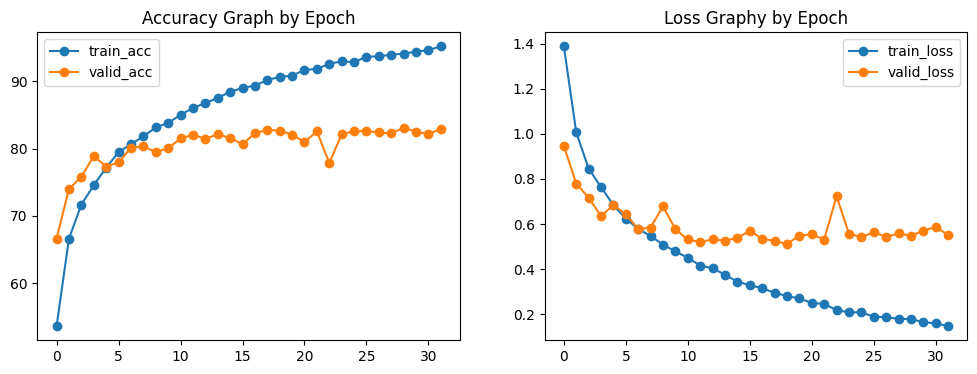

======================== Epoch: 33 ========================


100%|██████████| 4000/4000 [00:55<00:00, 71.49it/s]


Train loss: 0.142, Train acc: 95.4%


100%|██████████| 1000/1000 [00:07<00:00, 137.46it/s]


Valid loss: 0.538, Valid acc: 83.3%


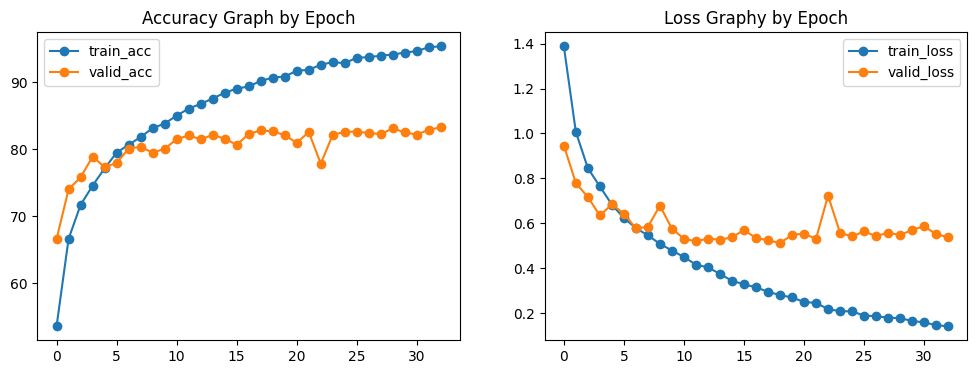

======================== Epoch: 34 ========================


100%|██████████| 4000/4000 [00:56<00:00, 71.23it/s]


Train loss: 0.136, Train acc: 95.4%


100%|██████████| 1000/1000 [00:07<00:00, 134.64it/s]


Valid loss: 0.577, Valid acc: 83.0%


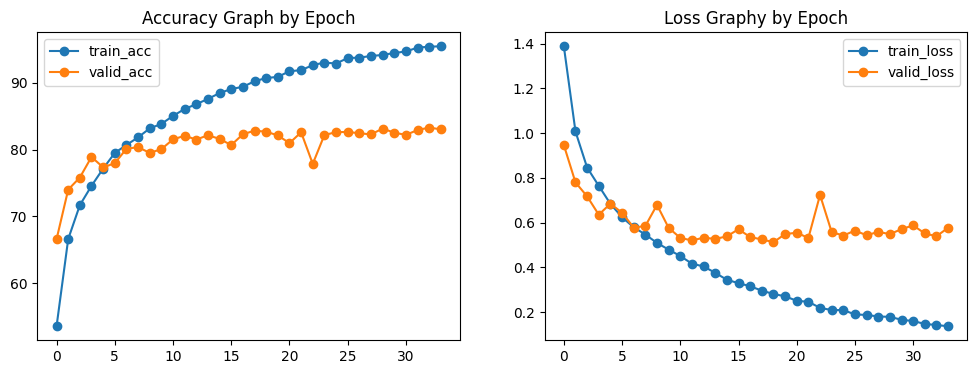

======================== Epoch: 35 ========================


100%|██████████| 4000/4000 [00:56<00:00, 71.29it/s]


Train loss: 0.127, Train acc: 95.8%


100%|██████████| 1000/1000 [00:07<00:00, 137.63it/s]


Valid loss: 0.584, Valid acc: 82.8%


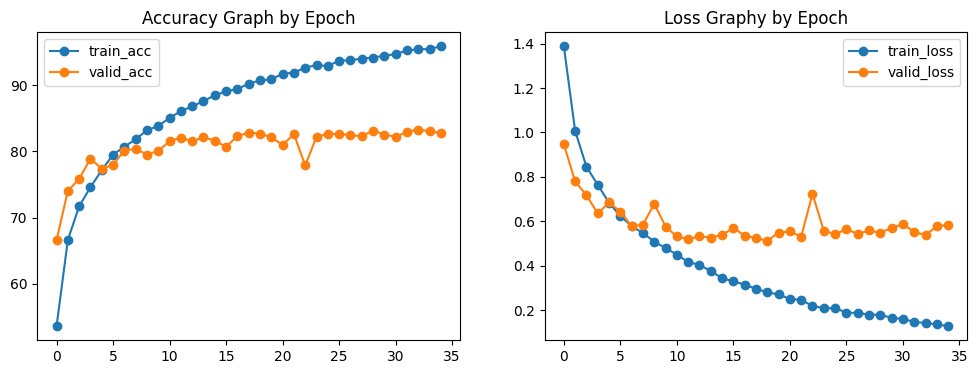

======================== Epoch: 36 ========================


100%|██████████| 4000/4000 [00:55<00:00, 71.82it/s]


Train loss: 0.129, Train acc: 95.7%


100%|██████████| 1000/1000 [00:07<00:00, 136.73it/s]


Valid loss: 0.579, Valid acc: 82.9%


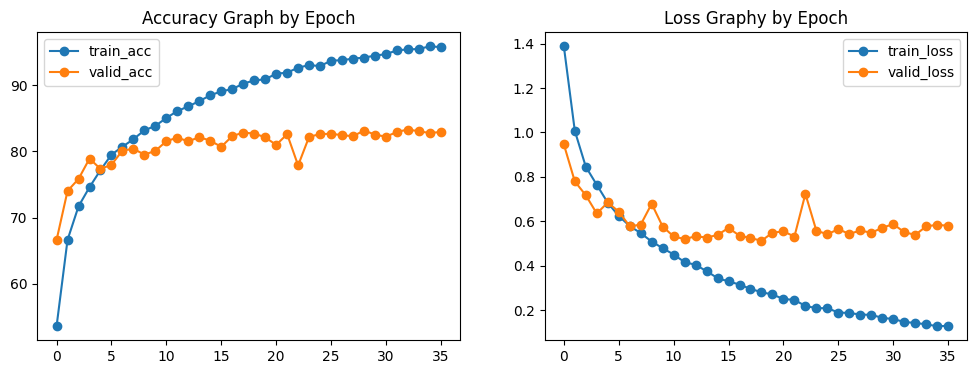

======================== Epoch: 37 ========================


100%|██████████| 4000/4000 [00:55<00:00, 71.86it/s]


Train loss: 0.114, Train acc: 96.2%


100%|██████████| 1000/1000 [00:07<00:00, 133.27it/s]


Valid loss: 0.580, Valid acc: 83.6%


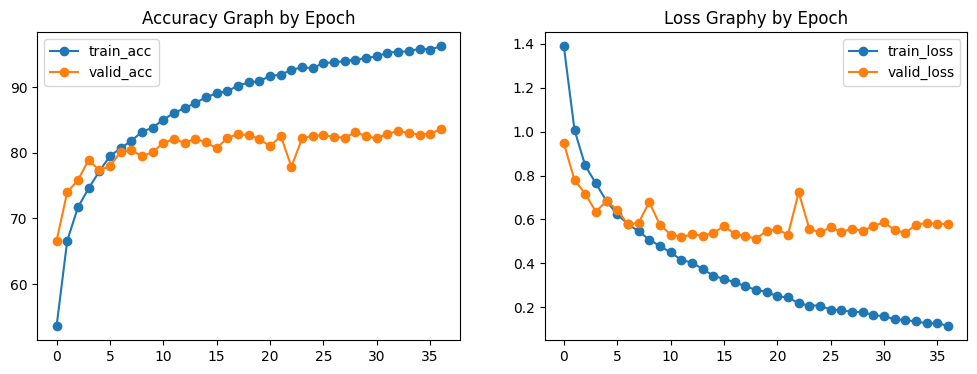

======================== Epoch: 38 ========================


100%|██████████| 4000/4000 [00:55<00:00, 72.33it/s]


Train loss: 0.116, Train acc: 96.2%


100%|██████████| 1000/1000 [00:07<00:00, 137.37it/s]


Valid loss: 0.604, Valid acc: 82.4%


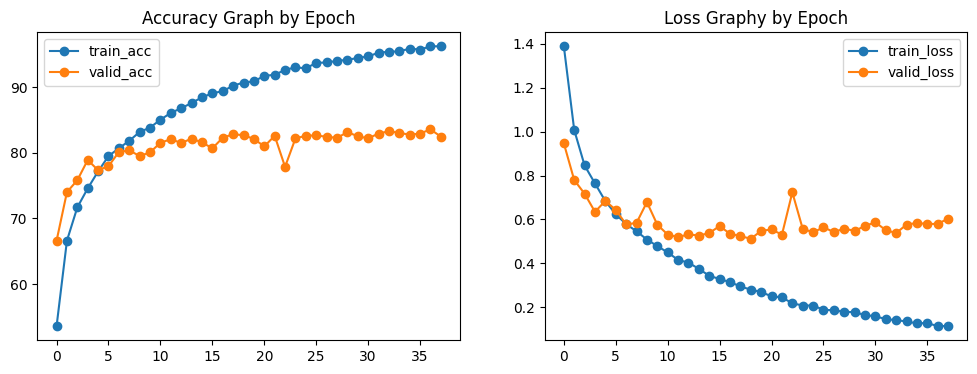

======================== Epoch: 39 ========================


100%|██████████| 4000/4000 [00:55<00:00, 72.53it/s]


Train loss: 0.110, Train acc: 96.4%


100%|██████████| 1000/1000 [00:07<00:00, 138.72it/s]


Valid loss: 0.572, Valid acc: 83.1%


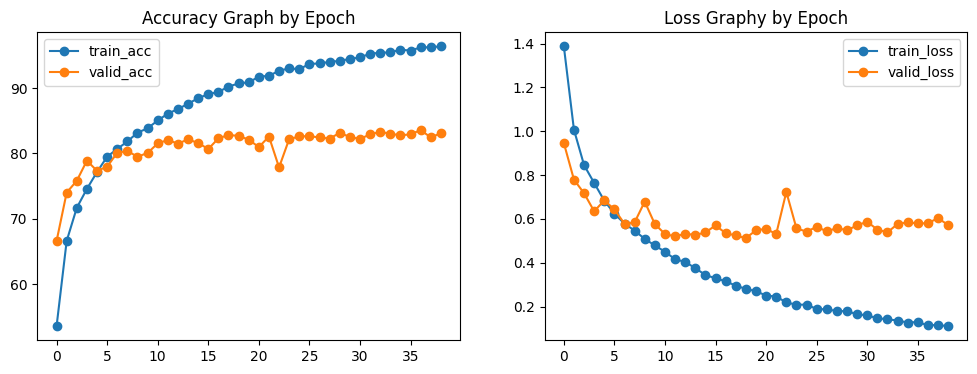

======================== Epoch: 40 ========================


100%|██████████| 4000/4000 [00:54<00:00, 72.88it/s]


Train loss: 0.101, Train acc: 96.7%


100%|██████████| 1000/1000 [00:07<00:00, 138.81it/s]


Valid loss: 0.607, Valid acc: 83.0%


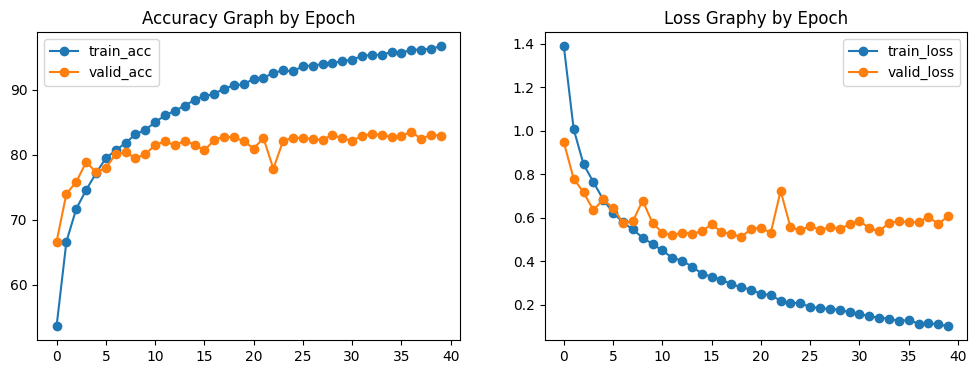

======================== Epoch: 41 ========================


100%|██████████| 4000/4000 [00:55<00:00, 72.44it/s]


Train loss: 0.100, Train acc: 96.8%


100%|██████████| 1000/1000 [00:07<00:00, 141.50it/s]


Valid loss: 0.597, Valid acc: 82.9%


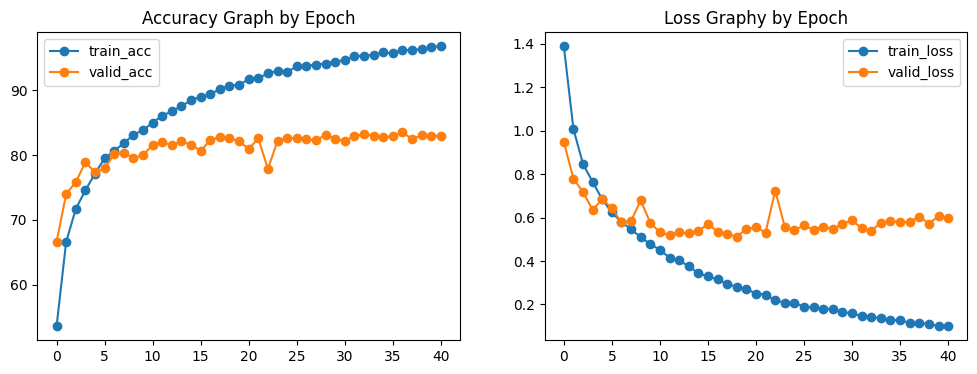

======================== Epoch: 42 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.13it/s]


Train loss: 0.097, Train acc: 96.9%


100%|██████████| 1000/1000 [00:07<00:00, 136.62it/s]


Valid loss: 0.580, Valid acc: 83.5%


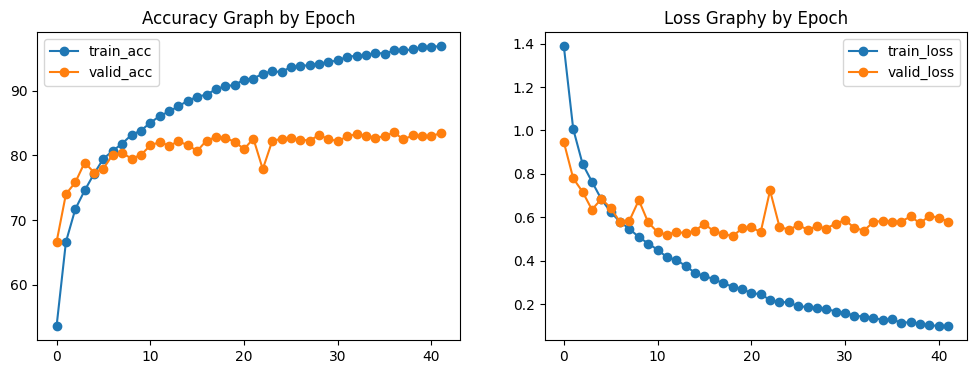

======================== Epoch: 43 ========================


100%|██████████| 4000/4000 [00:55<00:00, 72.13it/s]


Train loss: 0.101, Train acc: 96.6%


100%|██████████| 1000/1000 [00:07<00:00, 141.21it/s]


Valid loss: 0.616, Valid acc: 82.7%


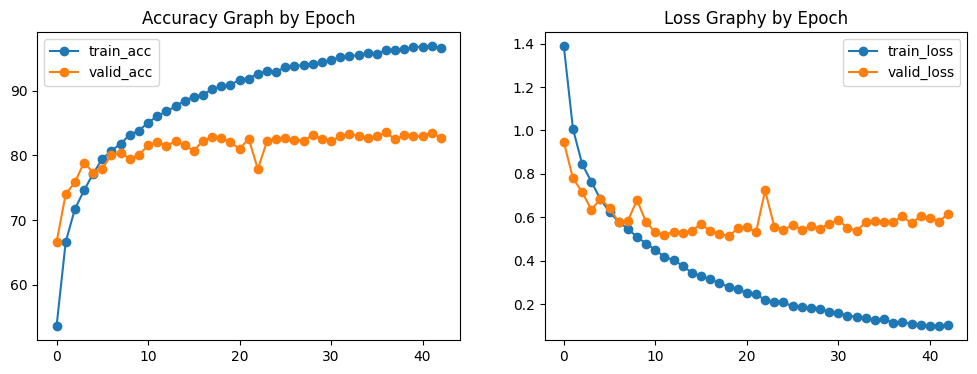

======================== Epoch: 44 ========================


100%|██████████| 4000/4000 [00:55<00:00, 71.74it/s]


Train loss: 0.097, Train acc: 96.8%


100%|██████████| 1000/1000 [00:07<00:00, 138.69it/s]


Valid loss: 0.597, Valid acc: 83.5%


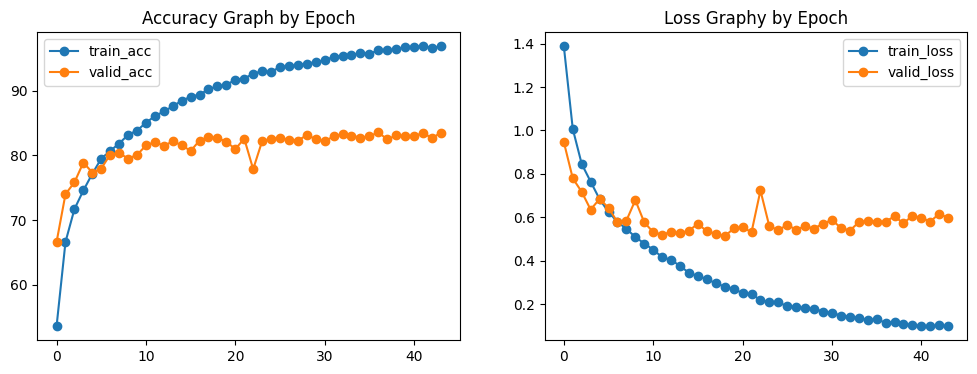

======================== Epoch: 45 ========================


100%|██████████| 4000/4000 [00:55<00:00, 72.31it/s]


Train loss: 0.091, Train acc: 97.0%


100%|██████████| 1000/1000 [00:07<00:00, 138.95it/s]


Valid loss: 0.613, Valid acc: 82.7%


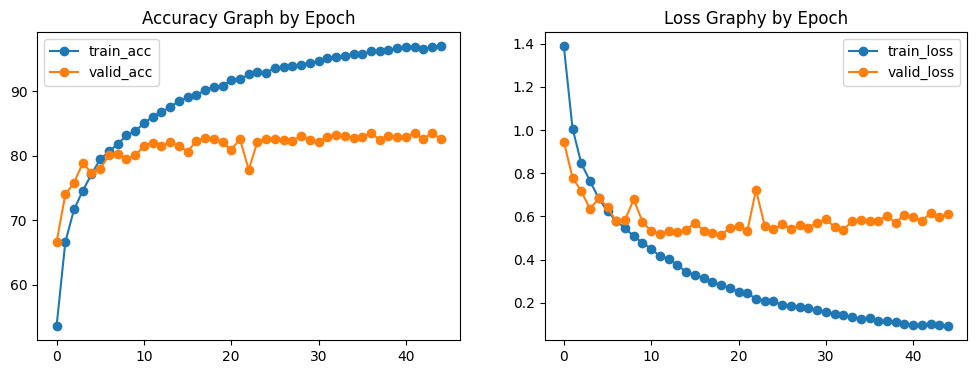

======================== Epoch: 46 ========================


100%|██████████| 4000/4000 [00:55<00:00, 72.51it/s]


Train loss: 0.088, Train acc: 97.2%


100%|██████████| 1000/1000 [00:07<00:00, 140.27it/s]


Valid loss: 0.604, Valid acc: 82.2%


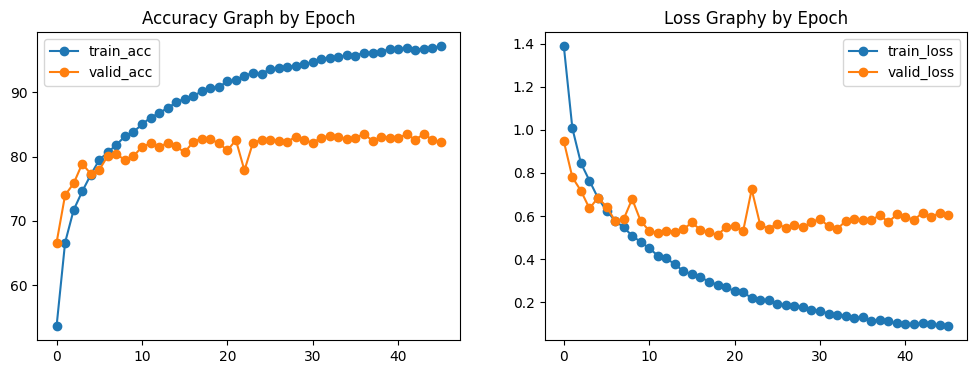

======================== Epoch: 47 ========================


100%|██████████| 4000/4000 [00:54<00:00, 74.06it/s]


Train loss: 0.080, Train acc: 97.3%


100%|██████████| 1000/1000 [00:07<00:00, 141.01it/s]


Valid loss: 0.602, Valid acc: 83.2%


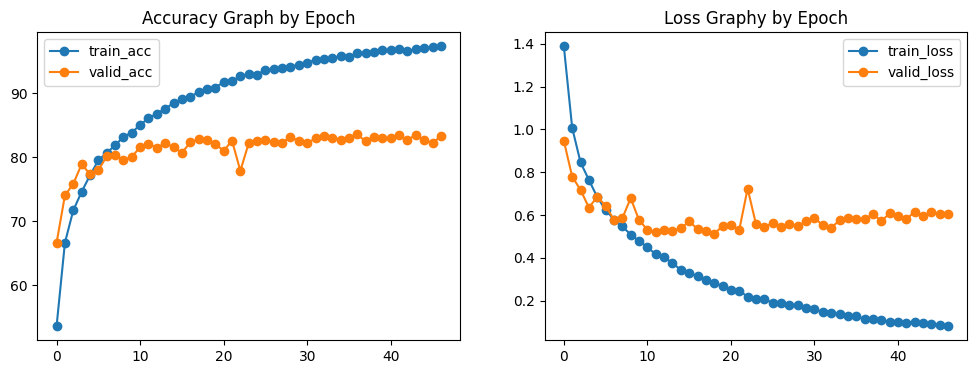

======================== Epoch: 48 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.83it/s]


Train loss: 0.082, Train acc: 97.3%


100%|██████████| 1000/1000 [00:07<00:00, 141.38it/s]


Valid loss: 0.606, Valid acc: 83.6%


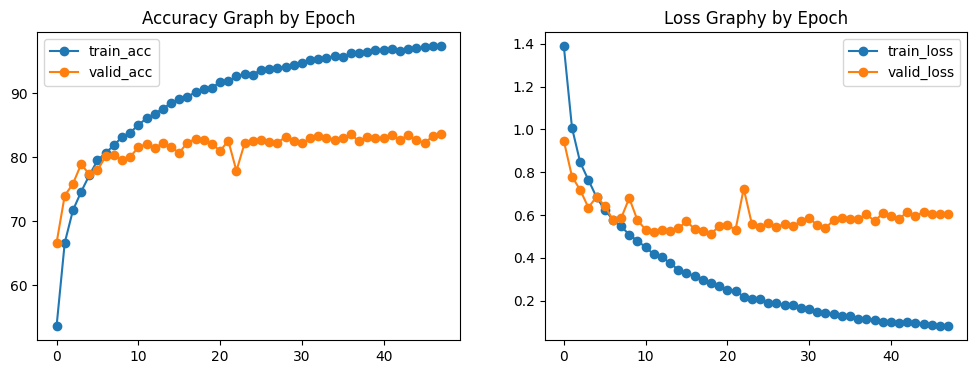

======================== Epoch: 49 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.69it/s]


Train loss: 0.076, Train acc: 97.6%


100%|██████████| 1000/1000 [00:07<00:00, 141.04it/s]


Valid loss: 0.624, Valid acc: 83.0%


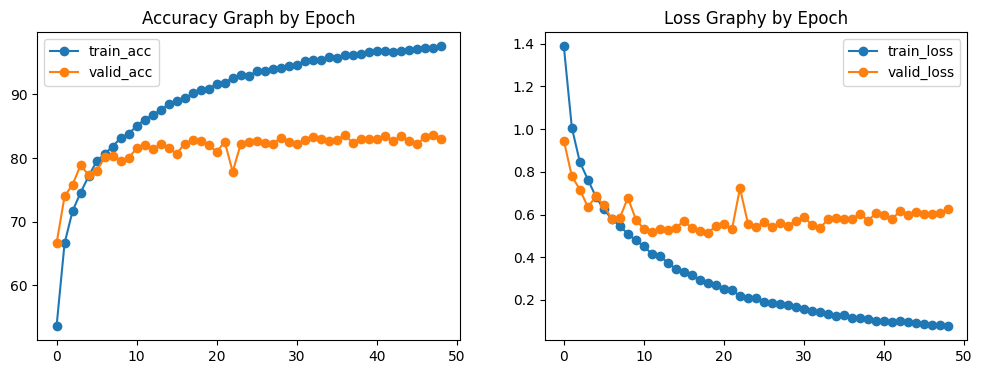

======================== Epoch: 50 ========================


100%|██████████| 4000/4000 [00:53<00:00, 74.38it/s]


Train loss: 0.071, Train acc: 97.7%


100%|██████████| 1000/1000 [00:06<00:00, 142.99it/s]


Valid loss: 0.623, Valid acc: 83.1%


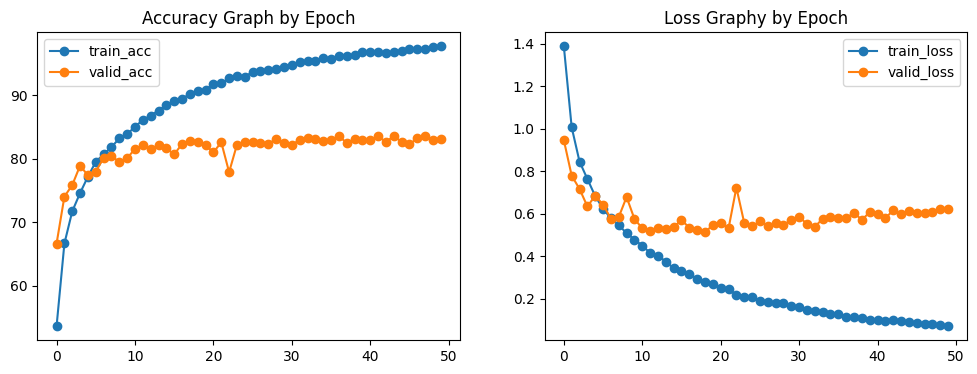

======================== Epoch: 51 ========================


100%|██████████| 4000/4000 [00:54<00:00, 72.98it/s]


Train loss: 0.072, Train acc: 97.6%


100%|██████████| 1000/1000 [00:07<00:00, 136.34it/s]


Valid loss: 0.625, Valid acc: 83.5%


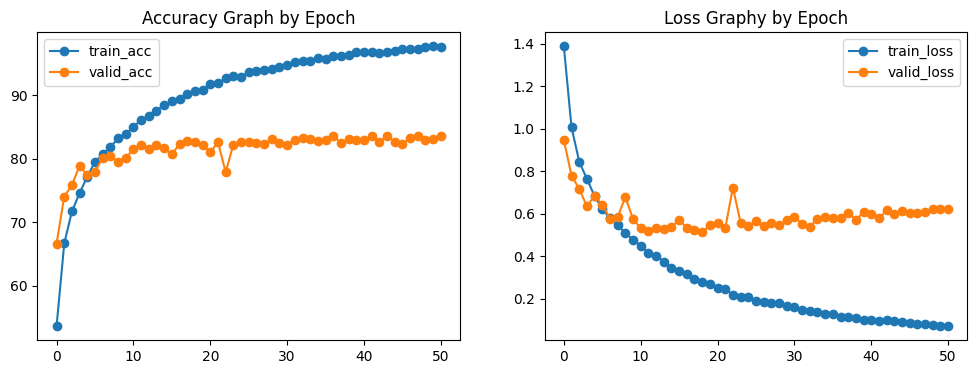

======================== Epoch: 52 ========================


100%|██████████| 4000/4000 [00:54<00:00, 73.33it/s]


Train loss: 0.074, Train acc: 97.5%


100%|██████████| 1000/1000 [00:07<00:00, 137.73it/s]


Valid loss: 0.617, Valid acc: 82.4%


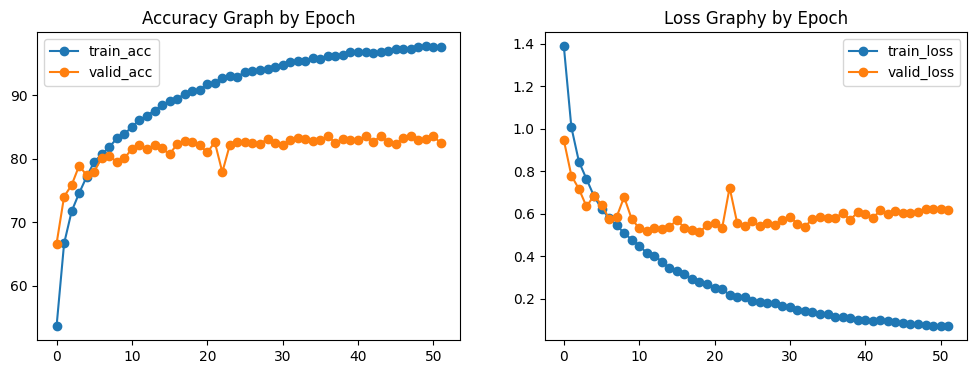

======================== Epoch: 53 ========================


 58%|█████▊    | 2315/4000 [00:31<00:22, 73.70it/s]


KeyboardInterrupt: 

In [7]:
valid_loss_min = np.Inf
train_epochs_loss = []
valid_epochs_loss = []
train_epochs_acc = []
valid_epochs_acc = []

for epoch in range(1, n_epochs+1):
    # Record train/valid loss and acc for each epoch
    train_loss_sum = 0.0
    valid_loss_sum = 0.0
    train_acc_num = 0.0
    valid_acc_num = 0.0
    # Start training and validating
    # ========================= train model =====================
    print('======================== Epoch: {} ========================'.format(epoch))
    model.train()
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item() * images.size(0)
        train_acc_num += sum(torch.max(logits, dim=1)[1] == labels).cpu()
    train_acc = 100 * train_acc_num/len(train_loader.dataset)
    train_loss = train_loss_sum/len(train_loader.dataset)
    train_epochs_loss.append(train_loss)
    train_epochs_acc.append(train_acc)
    print('Train loss: {:.3f}, Train acc: {:.1f}%'.format(train_loss, train_acc))

    # ========================= valid model =====================
    model.eval()
    for images, labels in tqdm(valid_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            loss = loss_fn(logits, labels)
        valid_loss_sum += loss.item() * images.size(0)
        valid_acc_num += sum(torch.max(logits, dim=1)[1] == labels).cpu()
    valid_acc= 100 * valid_acc_num/len(valid_loader.dataset)
    valid_loss = valid_loss_sum/len(valid_loader.dataset)
    valid_epochs_loss.append(valid_loss)
    valid_epochs_acc.append(valid_acc)
    print('Valid loss: {:.3f}, Valid acc: {:.1f}%'.format(valid_loss, valid_acc))

    # ========================= save model =====================
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.3f} --> {:.3f}).'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    
    # ========================= plot ==========================
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(train_epochs_acc, '-o', label="train_acc")
    plt.plot(valid_epochs_acc, '-o', label="valid_acc")
    plt.title("Accuracy Graph by Epoch")
    plt.legend()
    plt.subplot(122)
    plt.plot(train_epochs_loss, '-o', label="train_loss")
    plt.plot(valid_epochs_loss, '-o', label="valid_loss")
    plt.title("Loss Graphy by Epoch")
    plt.legend()
    plt.show()

## Testing

In [8]:
model.load_state_dict(torch.load('model_cifar.pt'))
cnf_matrix = torch.zeros(10, 10)
test_loss_sum = 0.0
test_acc_num = 0.0
# store the number of correct classified samples for each class
# and their total number
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))
# Store 10 sample well-classified images and their confidence value
correct_classfied_flags = [False for i in range(10)]
correct_classfied_samples = [i for i in range(10)]
correct_classfied_values = [0 for i in range(10)]
correct_classfied_preds = [0 for i in range(10)]
# Store 10 sample miss-classified images and their confidence value
miss_classfied_flags = [False for i in range(10)]
miss_classfied_samples = [i for i in range(10)]
miss_classfied_values = [0 for i in range(10)]
miss_classfied_preds = [0 for i in range(10)]

model.eval()
for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        logits = model(images)
        loss = loss_fn(logits, labels)
    test_loss_sum += loss.item() * images.size(0)
    pred = torch.max(logits, dim=1)[1]
    correct_tensor = pred == labels
    for idx in range(batch_size):
        # idx is the index of each image in one batch to RETRIVE from
        label = labels.data[idx].item()
        # label is the corresponding order of that image ot STORE in
        class_correct[label] += correct_tensor[idx].item()
        class_total[label] += 1
        if correct_tensor[idx] and not correct_classfied_flags[label]:
            correct_classfied_samples[label] = images.data[idx]
            correct_classfied_values[label] = max(nn.functional.softmax(logits[idx], dim=0)).item()
            correct_classfied_preds[label] = pred[idx].item()
            correct_classfied_flags[label] = True
        elif not correct_tensor[idx] and not miss_classfied_flags[label]:
            miss_classfied_samples[label] = images.data[idx]
            miss_classfied_values[label] = max(nn.functional.softmax(logits[idx], dim=0)).item()
            miss_classfied_preds[label] = pred[idx].item()
            miss_classfied_flags[label] = True   
    test_acc_num += sum(correct_tensor)
    cnf_matrix = confusion_matrix(pred, labels, cnf_matrix)

test_loss = test_loss_sum/len(test_loader.dataset)
test_acc = 100 * test_acc_num/len(test_loader.dataset)
print('Test Loss: {:.3f}, Test Acc: {:.1f}%'.format(test_loss, test_acc))
print('Test Accuracy by Class:')
for i in range(10):
    if class_total[i] > 0:
        print('{:8s}\t {:.1f}% ({:d}/{:d})'.format(class_names[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_names[i]))

100%|██████████| 1000/1000 [00:07<00:00, 128.90it/s]

Test Loss: 0.519, Test Acc: 82.9%
Test Accuracy by Class:
airplane	 82.2% (822/1000)
automobile	 90.5% (905/1000)
bird    	 71.3% (713/1000)
cat     	 71.4% (714/1000)
deer    	 80.4% (804/1000)
dog     	 74.2% (742/1000)
frog    	 93.6% (936/1000)
horse   	 86.0% (860/1000)
ship    	 89.2% (892/1000)
truck   	 90.6% (906/1000)


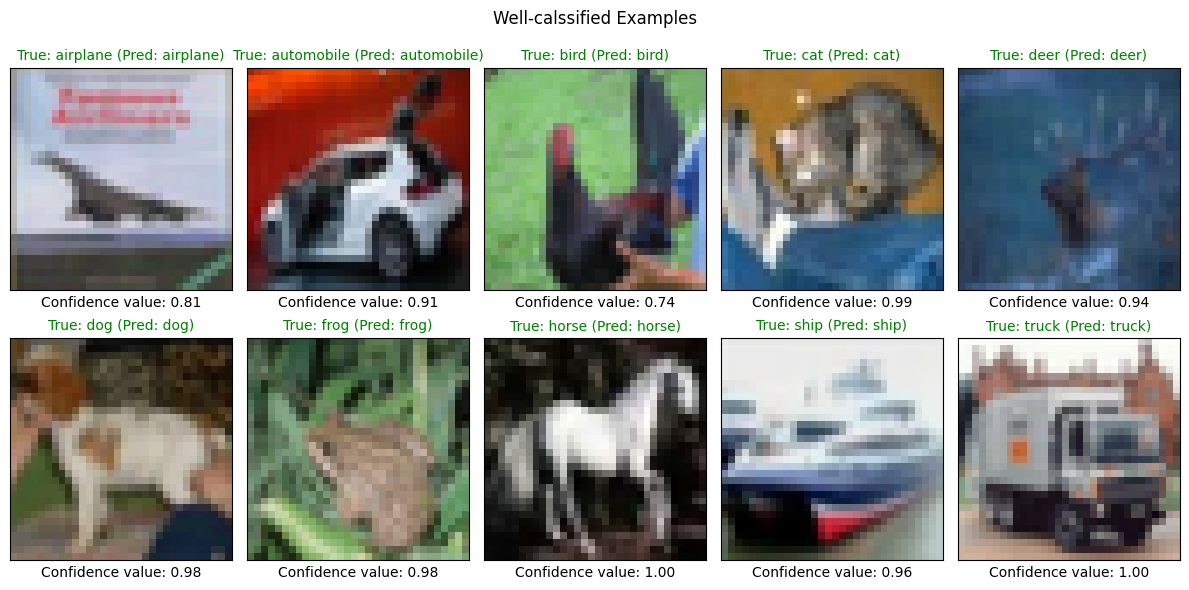

In [9]:
plot_class_samples(correct_classfied_samples, correct_classfied_preds, correct_classfied_values, title='Well-calssified Examples')

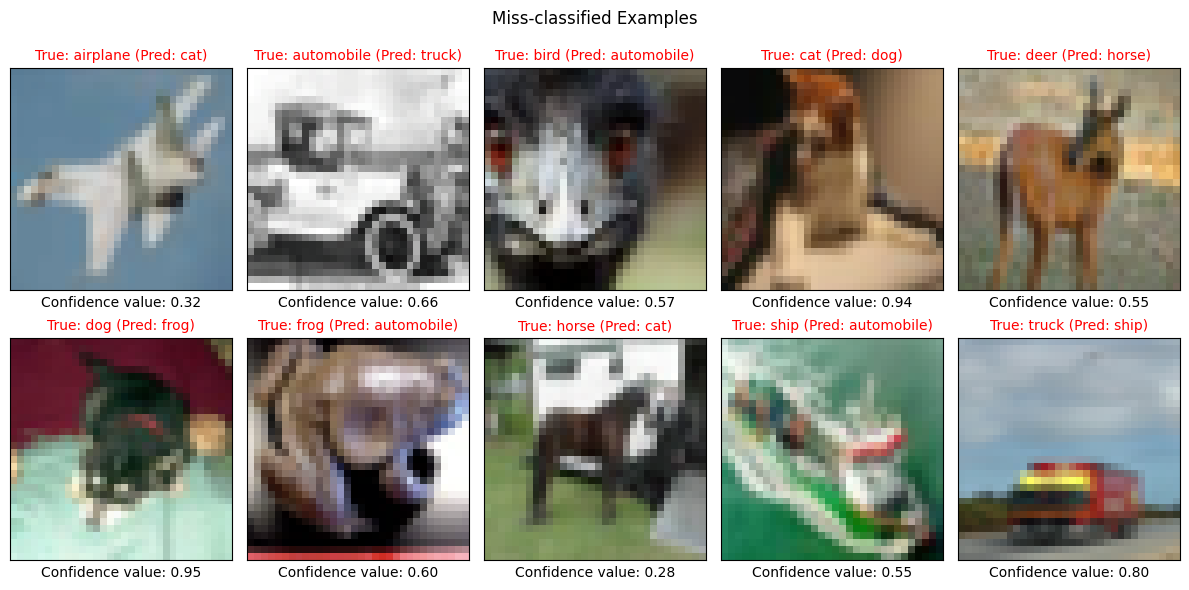

In [10]:
plot_class_samples(miss_classfied_samples, miss_classfied_preds, miss_classfied_values, title='Miss-classified Examples')

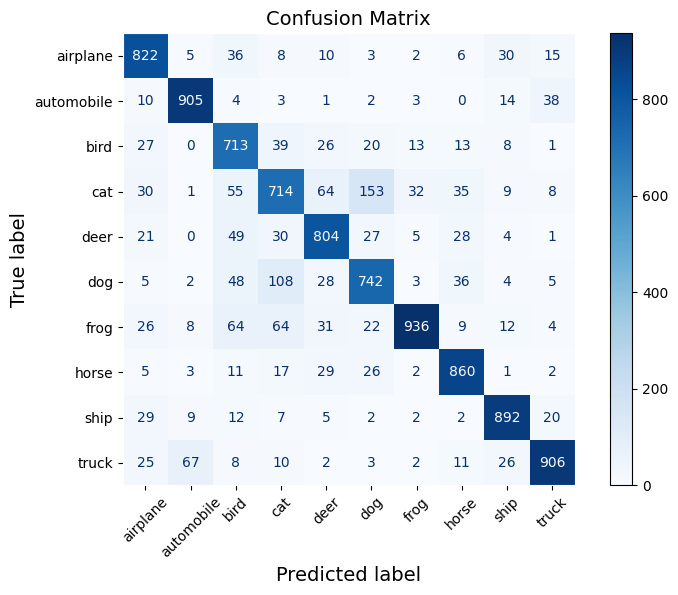

In [11]:
plot_confusion_matrix(cnf_matrix.numpy(), class_names, normalize=False, ax_display=False, title='Confusion Matrix')